In [48]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

In [49]:
# from src.physics.navier_stokes_fvm import *
# from src.utils.data_utils import get_bc_dict

def get_bc_dict():
    U_bc_dict = {
                'inlet':{ "type":'fixedValue', "value":[1,0,0] },
                'outlet':{ "type":'zeroGradient'},  
                'cylinder':{ "type":'noSlip'},  
                'frontAndBack':{ "type":'empty'}, 
                }
    p_bc_dict = {
        'inlet':{ "type":'zeroGradient' },
        'outlet':{ "type":'zeroGradient'},  
        'cylinder':{ "type":'zeroGradient'},  
        'frontAndBack':{ "type":'empty' } ,
        }
    return {'U':U_bc_dict, 'p':p_bc_dict}

In [ ]:
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cylinder_steady_re1\case.foam'
vtk_file_reader = pv.POpenFOAMReader(dir)
dtype = torch.float32

# Get Mesh
mesh = gaus_green_vfm_mesh(vtk_file_reader, dtype=dtype, bc_dict=get_bc_dict())
#mesh.add_bc_conditions(get_bc_dict())

Trying to fetch cell centers and volume from mesh...
Cell centers and Volumes fetched successfully
Calculating face centers and areas for 96229 faces
{'max_non_orthogonality': 42.362083435058594, 'avg_non_orthogonality': 5.40273904800415, 'max_skewness': 0.4661012887954712, 'avg_skewness': 0.0499868169426918}
 Found Patch "inlet" with 156 Faces
 Found Patch "outlet" with 156 Faces
 Found Patch "cylinder" with 627 Faces
Boundary faces indexed: 939/54763 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.2051,               max w:0.8097,               mean w:0.5017


In [51]:
nu = 0.025
Re = 1/nu 
sample_solution_U = mesh.vtk_mesh.cell_data['U']
sample_solution_p = mesh.vtk_mesh.cell_data['p']

sample_u = torch.tensor(sample_solution_U[...,:2],dtype=dtype).reshape(-1,2).unsqueeze(0).unsqueeze(0)
sample_u = torch.nn.functional.pad(sample_u, (0, 1))
sample_p = torch.tensor(sample_solution_p,dtype=dtype).reshape(-1,1).unsqueeze(0).unsqueeze(0)

_, gradp_pred = Divergence_Operator.caclulate(mesh, field=sample_p, field_type='p')
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=sample_u)
lap_pred = Laplacian_Operator.caclulate(mesh, field=sample_u, correction_method=mesh.correction_method, gradient_field=gradU_pred)

mom_pred = divU_pred - (1/Re)*lap_pred + gradp_pred

In [52]:
gt_div = torch.tensor(mesh.vtk_mesh.cell_data['divU_phiAll'])
gt_lap = torch.tensor(mesh.vtk_mesh.cell_data['lapU'])
gt_gradu = torch.tensor(mesh.vtk_mesh.cell_data['grad(U)'])
gt_gradp = torch.tensor(mesh.vtk_mesh.cell_data['grad(p)'])

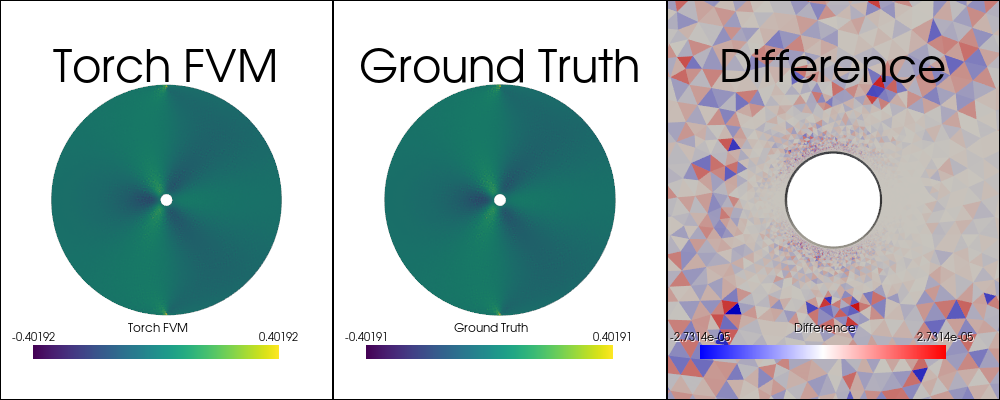

In [53]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction = divU_pred.squeeze(0).squeeze(0),
                    ground_truth = gt_div.squeeze(0).squeeze(0),
                    #clims3=[-0.00001,0.00001],
                    zoom=True
                    )

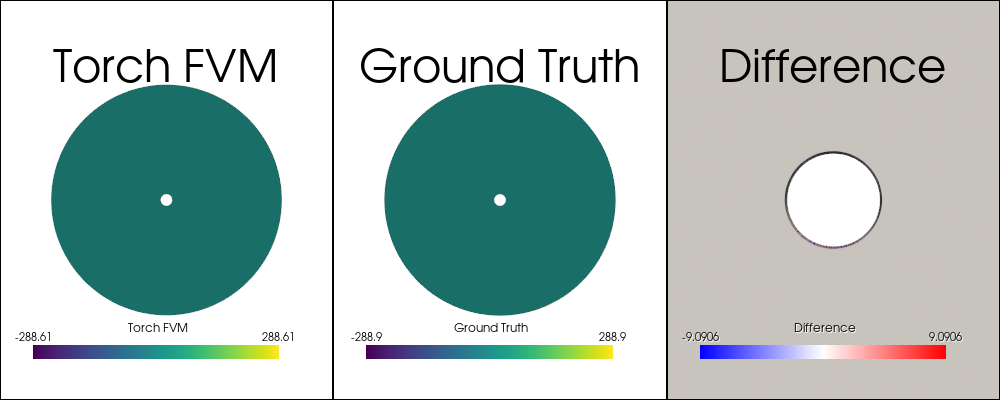

In [54]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction = lap_pred.squeeze(0).squeeze(0),
                    ground_truth = gt_lap.squeeze(0).squeeze(0),
                    #clims3=[-0.00001,0.00001],
                    zoom=True
                    )

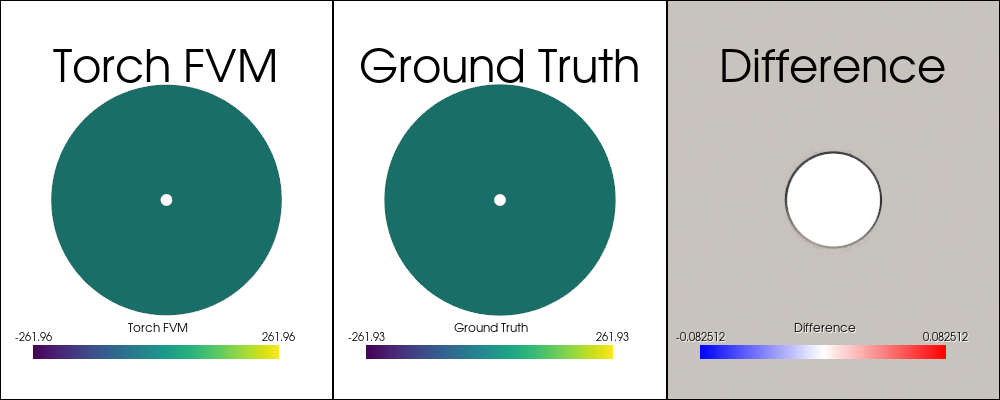

In [55]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction = gradp_pred.squeeze(0).squeeze(0),
                    ground_truth = gt_gradp.squeeze(0).squeeze(0),
                    #clims3=[-0.00001,0.00001],
                    zoom=True
                    )

## Equations

In [56]:
gt_momx = gt_div[...,0] -gt_gradp[...,0] -gt_lap[...,0]*(1/Re)
momx_pred = divU_pred[...,0] -gradp_pred[...,0] - lap_pred[...,0]*(1/Re)

In [57]:
print('Ground Truth', gt_momx.min(), gt_momx.max(), gt_momx.mean())
print('Torch FVM Truth', momx_pred.min(), momx_pred.max(), momx_pred.mean())

Ground Truth tensor(-266.7079) tensor(263.1897) tensor(0.3621)
Torch FVM Truth tensor(-266.7310) tensor(263.2267) tensor(0.3621)


In [58]:
from src.utils.training_utils import LpLoss
loss_fn = LpLoss()

In [59]:
loss = loss_fn(gt_momx.unsqueeze(0), y=torch.zeros_like(gt_momx.unsqueeze(0)))
print('Ground Truth', loss)
loss = loss_fn(momx_pred.squeeze(0).squeeze(0), y=torch.zeros_like(momx_pred.squeeze(0).squeeze(0)))
print('Torch FVM Truth', loss)
print('Relative Comparison', loss_fn(momx_pred.unsqueeze(0), gt_momx.unsqueeze(0)))

Ground Truth tensor(18.1918)
Torch FVM Truth tensor(0.0382)
Relative Comparison tensor(0.0129)


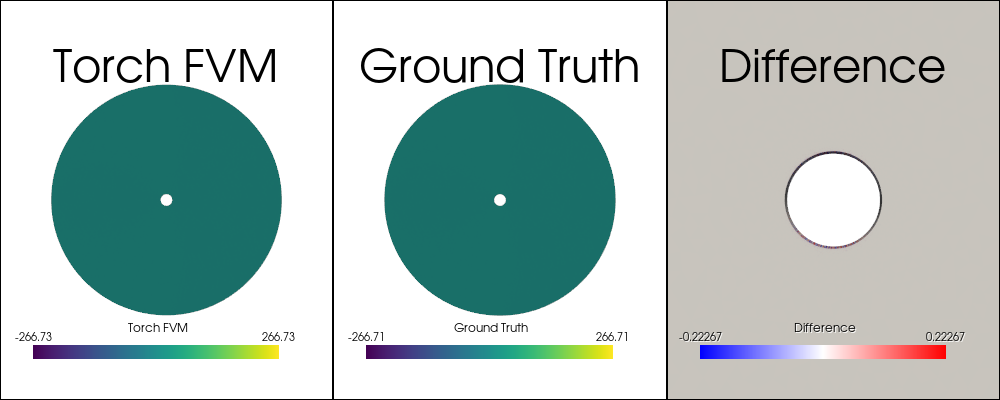

In [ ]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction = momx_pred.squeeze(0).squeeze(0).unsqueeze(-1),
                    ground_truth = gt_momx.squeeze(0).squeeze(0).unsqueeze(-1),
                    clims2=[-10,10],
                    #clims3=[-0.00001,0.00001],
                    zoom=True
                    )

In [64]:
print(torch.norm(gt_momx.reshape(1,-1),2, 1))
print(torch.norm(momx_pred.reshape(1,-1),2, 1))

tensor([2965.2676])
tensor([2965.2920])


## Pipeline Test

In [62]:
from src.gauss_green import gaus_green_vfm_mesh
from src.pde_controller import pde_controller

In [63]:
config = {'mesh_file_pointer': r'C:\Users\Noahc\Downloads\c5_test\case.foam',
            'enforcement_list': ['Continuity Loss', 'IC Loss'],
            'equations_limiters' : {'Continuity Loss' : 0.001
                },
            'dataset_channels' : {'U': [0,1],
                                'p': [2]
                                },
            'length_scale' : 2,
            'pde_equation' : 'navier_stokes_2d',
            'settings': {
                'verbose':                False,
                'ic_loss':                True,
                'pin_first_ts':           True,
                'pde_loss':               True,
                'mom_eqn_skip_first_ts':  False,
                'soblov_norms':           False,   # Not Implemented yet
                'dt_scheme':              'backwards'
            },
            'enforcement_list': ['IC Loss'],
            'equations_limiters': {}
        }